In [1]:
# imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D
# me defined 
from dataloader import DatasetGenerator as dg
from modeling import ModelBuilder as mb
from evaluation import Evaluator as ev

Synthetic Data

In [2]:
# 4 input values, each Gaussian distributed with 0 mean and 1 stdev
# 1 output value, distance from the origin, AKA L2-norm
# 1000 instances for training, 1000 for testing

(1000,)
min_val y in before norm:  0.2786556530357897
max_val y in before norm:  4.266166074261009
(1000,)
min_val y in before norm:  0.3258431295941944
max_val y in before norm:  4.667305181025433
X_train:  [[ 0.3211592  -1.28337339  1.82615861 -0.48424969]
 [-2.80952564  0.71714926  0.15809093 -1.88665224]
 [-0.12068161 -1.33804002  0.48589791  0.4370606 ]
 [ 0.31261121  1.33756379 -0.34419078  2.31614202]]
y_train:  [1.0170546  1.59714594 0.60957516 1.22185457]
X_test:  [[-0.71435543 -0.29229317 -2.96883124  1.02941439]
 [-1.68545327  0.4443915   1.73094948  0.48414846]
 [-1.0947998   0.79788346  0.70381239 -0.31855487]
 [ 0.60213346 -0.19276767  0.49084641 -0.62899898]]
y_test:  [1.34047047 1.00331109 0.56831305 0.31885209]
min_val y in after norm:  0.0
max_val y in after norm:  2.0


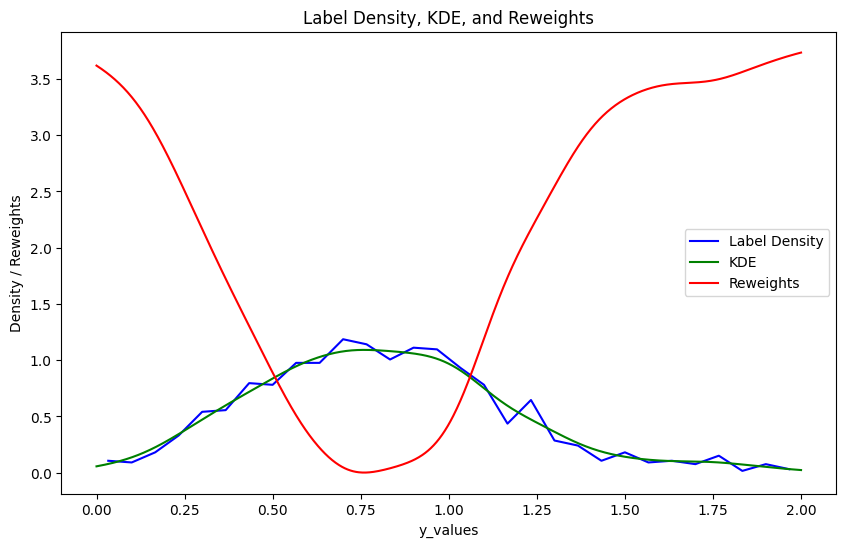

0.0 2.0


In [3]:
# Generate synthetic data
n_train = 1000
n_test = 1000
loader = dg(n_train, n_test)
print(loader.min_y, loader.max_y)

In [4]:
# print first 4 of reweights 
print(loader.reweights[:4])

[0.53119948 3.43553978 0.31032123 2.09508002]


Model Building

In [5]:
# NN for representation learning:
# 4 input nodes
# 1 or more hidden layers
# the last hidden layer has 2 nodes (representation layer Z)
# plot the instances in the 2D feature/representation space of Z 
# use different colors for different target values (can be in groups, each group with a different color) similar to the RankSim pictures
# training and test sets in different plots.
# expecting the instances to be in a semi-circle
# for prediction, add output layer of 1 node.

mb = mb()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32)                0     

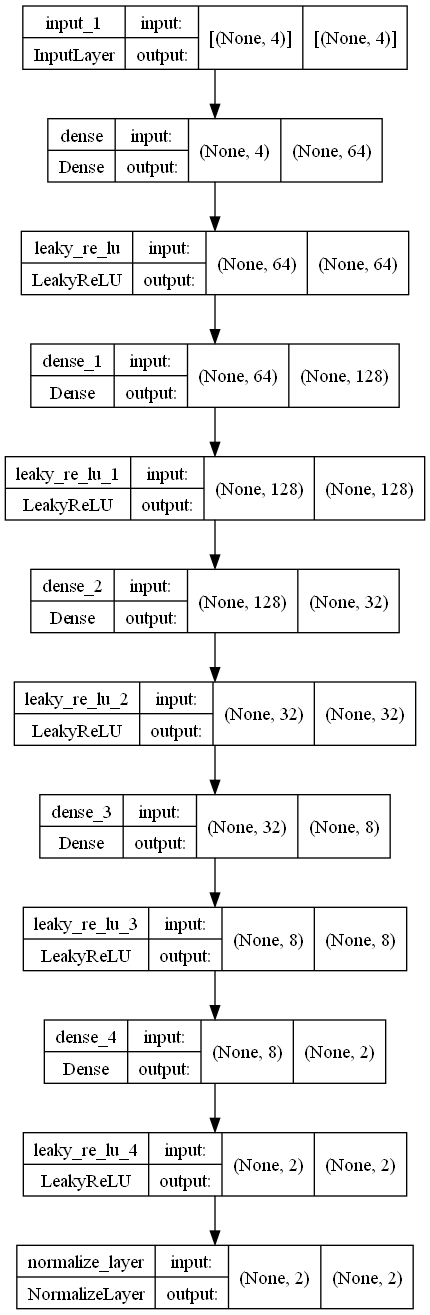

In [6]:
# Create and train the model
hiddens = [64, 128, 32, 8]
model = mb.create_model_feat(4, 2, hiddens)
# summarize and plot the model
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

Test of First Idea improving on ranksim

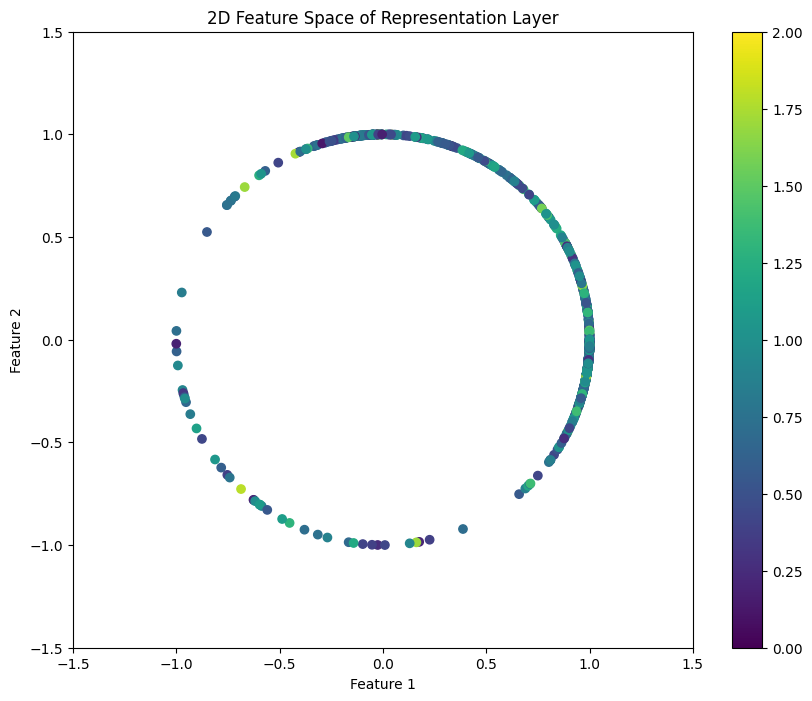

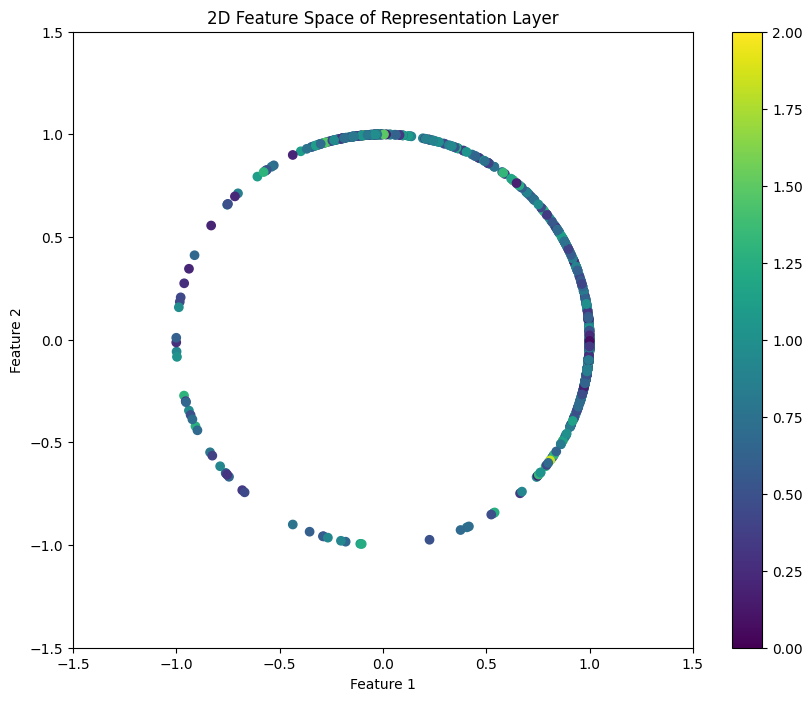

In [7]:
eva = ev()
# Plot the 2D feature space
eva.plot_feature_space(model, loader.X_train, loader.y_train)
eva.plot_feature_space(model, loader.X_test, loader.y_test)

Run the command line:
 tensorboard --logdir logs/fit
Epoch 1/400
50/50 [==============================] - 11s 177ms/step - loss: 27.1131 - val_loss: 19.9949
Epoch 2/400
50/50 [==============================] - 7s 147ms/step - loss: 19.9230 - val_loss: 20.2293
Epoch 3/400
50/50 [==============================] - 7s 148ms/step - loss: 20.5431 - val_loss: 19.3437
Epoch 4/400
50/50 [==============================] - 8s 152ms/step - loss: 19.7737 - val_loss: 17.6851
Epoch 5/400
50/50 [==============================] - 8s 155ms/step - loss: 13.7417 - val_loss: 8.1103
Epoch 6/400
50/50 [==============================] - 8s 165ms/step - loss: 6.6773 - val_loss: 7.2385
Epoch 7/400
50/50 [==============================] - 8s 168ms/step - loss: 5.3833 - val_loss: 6.0558
Epoch 8/400
50/50 [==============================] - 8s 155ms/step - loss: 4.5123 - val_loss: 3.6085
Epoch 9/400
50/50 [==============================] - 7s 149ms/step - loss: 2.1734 - val_loss: 1.9409
Epoch 10/400
50/50 [========

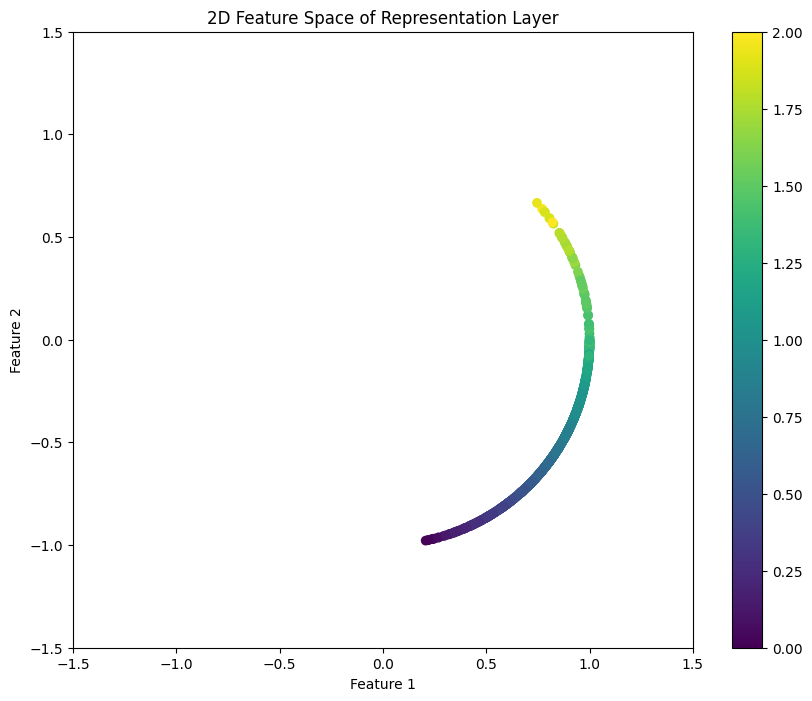

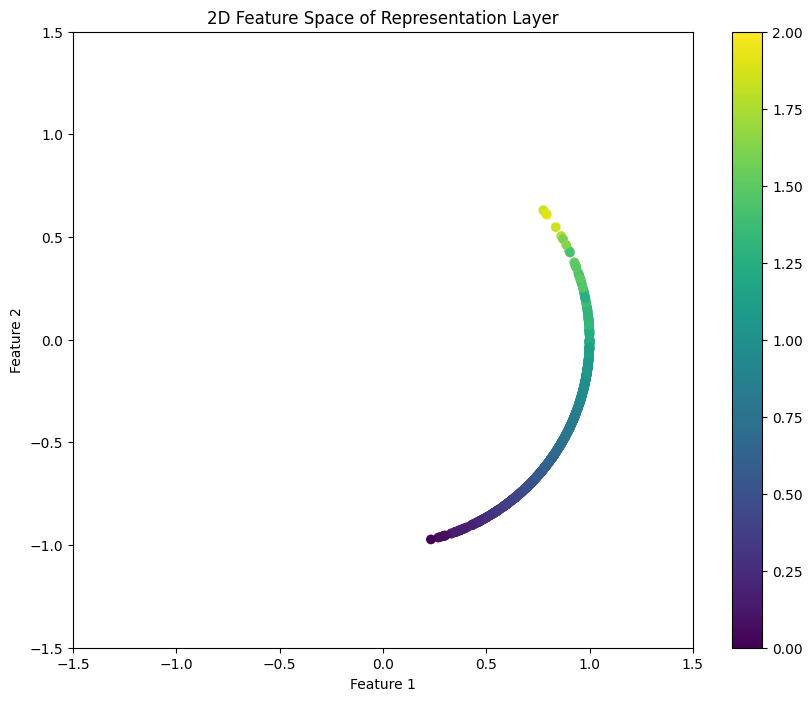

In [8]:
history = mb.train_features(model, loader.X_train, loader.y_train, learning_rate=1e-3, epochs=400, batch_size=16)

# plot_feature_space(model, X_train, y_train)
# Plot the 2D feature space
eva.plot_feature_space(model, loader.X_train, loader.y_train)
eva.plot_feature_space(model, loader.X_test, loader.y_test)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32)                0   

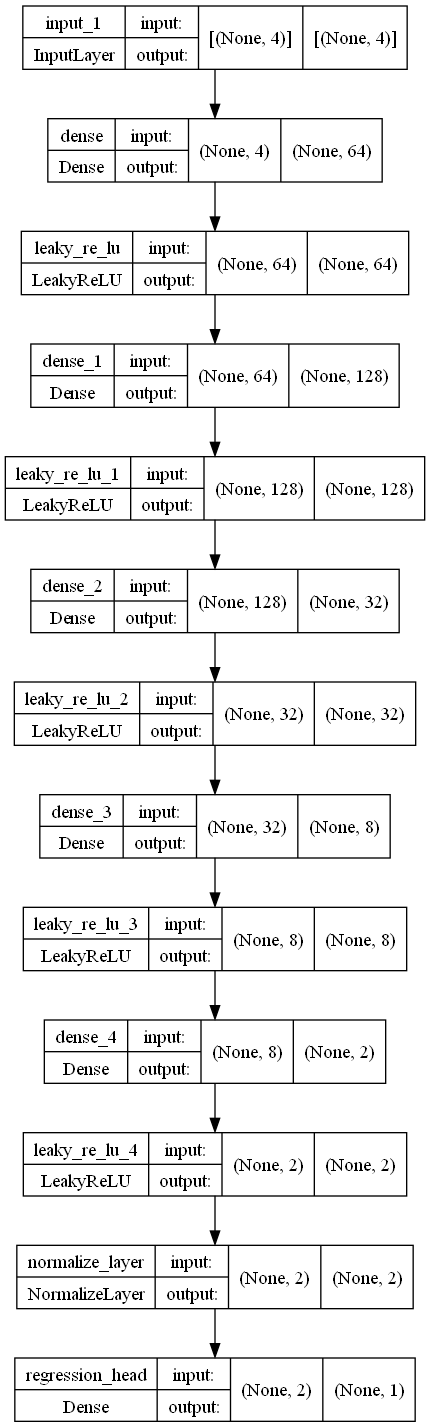

In [9]:
# add regression head
extended_model = mb.add_regression_head(model)
# summarize and plot the model
extended_model.summary()
tf.keras.utils.plot_model(extended_model, show_shapes=True)

In [10]:
# train now with the regression stage with balanced loss
history = mb.train_regression(extended_model, loader.X_train, loader.y_train, loader.reweights, learning_rate=1e-4, epochs=400, batch_size=16)

Run the command line:
 tensorboard --logdir logs/fit
Epoch 1/400
50/50 [==============================] - 1s 14ms/step - loss: 0.4905 - regression_head_loss: 0.4905 - regression_head_mse: 0.2686 - val_loss: 0.4470 - val_regression_head_loss: 0.4470 - val_regression_head_mse: 0.2540
Epoch 2/400
50/50 [==============================] - 0s 7ms/step - loss: 0.4737 - regression_head_loss: 0.4737 - regression_head_mse: 0.2538 - val_loss: 0.4355 - val_regression_head_loss: 0.4355 - val_regression_head_mse: 0.2428
Epoch 3/400
50/50 [==============================] - 0s 8ms/step - loss: 0.4611 - regression_head_loss: 0.4611 - regression_head_mse: 0.2437 - val_loss: 0.4248 - val_regression_head_loss: 0.4248 - val_regression_head_mse: 0.2335
Epoch 4/400
50/50 [==============================] - 0s 7ms/step - loss: 0.4503 - regression_head_loss: 0.4503 - regression_head_mse: 0.2344 - val_loss: 0.4152 - val_regression_head_loss: 0.4152 - val_regression_head_mse: 0.2248
Epoch 5/400
50/50 [===========

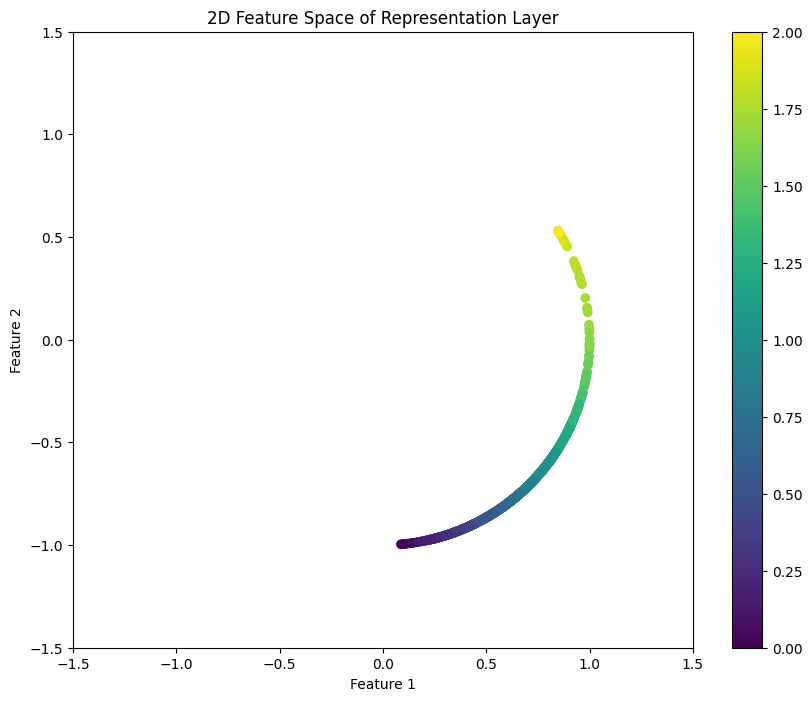

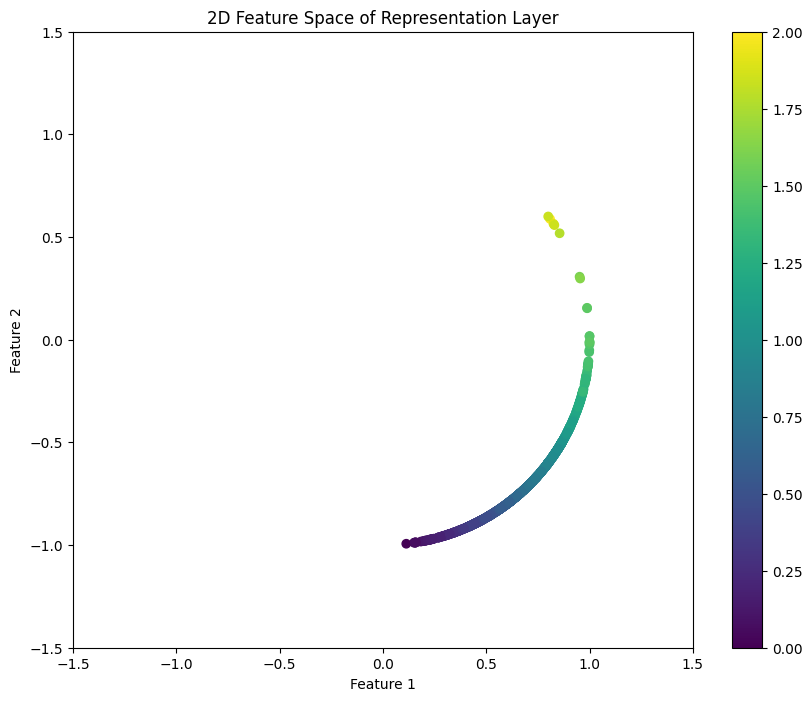

In [11]:
# plot_feature_space(model, X_train, y_train)
# Plot the 2D feature space
eva.plot_feature_space(extended_model, loader.X_train, loader.y_train, withhead=True)
eva.plot_feature_space(extended_model, loader.X_test, loader.y_test, withhead=True)

In [12]:
eva.evaluate(extended_model, loader.X_test, loader.y_test)

Mean Squared Error: 0.22908109426498413


77.09189057350159

In [201]:
def jpdf(ya: tf.Tensor, yb: tf.Tensor, kde) -> tf.Tensor:
    """
    Joint Probability Density Function for two independent variables ya and yb.

    :param kde: The kernel density estimation object.
    :param ya: The first y value as a TensorFlow tensor.
    :param yb: The second y value as a TensorFlow tensor.
    :return: The product of the probability densities at ya and yb as a TensorFlow tensor.
    """
    
    def py_jpdf(ya, yb):
        # Density of ya and yb
        density_ya = kde.evaluate(ya)
        density_yb = kde.evaluate(yb)
    
        # Joint density
        joint_density = density_ya * density_yb
    
        return joint_density[0]

    return tf.py_function(func=py_jpdf, inp=[ya, yb], Tout=tf.float32)

# Generate synthetic labels (replace this with your y_train)
y_train = np.random.normal(1, 0.2, 1000)

# Create a KDE object using Scott's method
kde_scott = gaussian_kde(y_train, bw_method='scott')

# Test the joint PDF function
ya, yb = 1, 1
result = jpdf(ya, yb, kde_scott)
print(f"The joint density at ya = {ya}, yb = {yb} is {result}")

The joint density at ya = 1, yb = 1 is 3.767122268676758


In [176]:
# Initialize min and max variables to store the minimum and maximum jpdf values
min_jpdf = float("inf")
max_jpdf = float("-inf")

# Calculate the jpdf for each unique pair in y_train
for i in range(len(y_train)):
    for j in range(i + 1, len(y_train)):  # start from i to avoid duplicate pairs
        current_jpdf = jpdf(y_train[i], y_train[j], kde_scott)
        
        min_jpdf = min(min_jpdf, current_jpdf)
        max_jpdf = max(max_jpdf, current_jpdf)

print("Minimum JPDF value:", min_jpdf)
print("Maximum JPDF value:", max_jpdf)

Minimum JPDF value: 0.00025499212994878416
Maximum JPDF value: 3.5998997393759535


In [209]:
def reweight(ya: float, yb: float, min_jpdf: float, max_jpdf: float, kde: gaussian_kde, alpha: float, epsilon: float=1e-7) -> float:
    """
    Calculate the reweighting factor for a pair of labels ya and yb.

    :param ya: The y-value of the first data point.
    :param yb: The y-value of the second data point.
    :param min_jpdf: The minimum jpdf value in the dataset.
    :param max_jpdf: The maximum jpdf value in the dataset.
    :param kde_model: Trained KDE model.
    :param alpha: Parameter to adjust the reweighting.
    :param epsilon: A small constant to avoid zero reweighting.
    :return: The reweighting factor for the pair ya, yb.
    """

    # Compute the joint density of ya and yb
    joint_density = jpdf(ya, yb, kde)

     # Make sure joint_density is a tensor with proper shape and dtype
    joint_density = tf.ensure_shape(joint_density, ())

    # Normalize the joint density
    normalized_jpdf = (joint_density - min_jpdf) / (max_jpdf - min_jpdf)

    # Compute the reweighting factor
    reweighting_factor = tf.math.maximum(1 - alpha * normalized_jpdf, epsilon)

    return reweighting_factor

In [ ]:
alpha = 1 # TODO: find the right alpha
reweighting_result = reweight(1.7, 2.0, min_jpdf, max_jpdf, kde_scott, alpha)
print("Reweighting result:", reweighting_result)

In [186]:
total_reweight = 0.0
n = len(y_train)
# Iterate through unique pairs ya, yb
for i in range(n):
    for j in range(i+1, n):  # j starts from i+1 to ensure ya != yb and avoid duplicate pairs
        ya = y_train[i]
        yb = y_train[j]

        # Compute reweighting for this pair using the function 'reweight'
        rw = reweight(ya, yb, min_jpdf, max_jpdf, kde_scott, alpha)

        # Add to the total sum
        total_reweight += rw
        
total_reweight /= ((n * (n - 1)) / 2)

print("Total sum of reweighting for all unique pairs:", total_reweight)

Total sum of reweighting for all unique pairs: 0.4841564855095299


In [204]:
def normalized_reweight(ya, yb, min_jpdf, max_jpdf, kde=kde_scott, alpha=1, epsilon=1e-7, total_sum=total_reweight):
    """
    Calculate the normalized reweighting factor for a given pair of labels ya and yb.
    
    :param ya, yb: The pair of labels
    :param min_jpdf, max_jpdf: Min and max values of the joint PDF for normalization
    :param kde: The KDE model
    :param alpha: The alpha parameter
    :param epsilon: The epsilon constant
    :param total_sum: The total sum of all reweighting values
    :return: The normalized reweighting value
    """
    raw_reweight = reweight(ya, yb, min_jpdf, max_jpdf, kde, alpha, epsilon)
    
    # Ensure total_sum is a TensorFlow tensor
    total_sum = tf.constant(total_sum, dtype=tf.float32)
    
    # Normalize by the total sum of reweighting
    normalized_reweight_val = tf.divide(raw_reweight, total_sum)
    
    return normalized_reweight_val


In [ ]:
alpha = 1 # TODO: find the right alpha
reweighting_result = normalized_reweight(1, 1, min_jpdf, max_jpdf, kde_scott, alpha)
print("Reweighting result:", reweighting_result)
reweighting_result = normalized_reweight(1, 1.7, min_jpdf, max_jpdf, kde_scott, alpha)
print("Reweighting result:", reweighting_result)

In [190]:
# Create the 3D figure
fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

# Parameters
alpha = 1
kde = kde_scott  # Replace with your KDE object
y_values = np.unique(y_train)  # Assuming y_train is your dataset
n_values = len(y_values)

# For storing the values
normalized_reweight_vals = np.zeros((n_values, n_values))
normalized_jpdf_vals = np.zeros((n_values, n_values))

# Calculate and plot
for i, ya in enumerate(y_values):
    for j, yb in enumerate(y_values):
        if ya != yb:
            # Calculate normalized jpdf and reweight
            jpdf_val = jpdf(ya, yb, kde)
            normalized_jpdf = (jpdf_val - min_jpdf) / (max_jpdf - min_jpdf)
            reweight_val = normalized_reweight(ya, yb, min_jpdf, max_jpdf, kde, alpha)

            # Store values
            normalized_jpdf_vals[i, j] = normalized_jpdf
            normalized_reweight_vals[i, j] = reweight_val

            # Plot
            ax1.scatter(ya, yb, normalized_jpdf, c='b')
            ax2.scatter(ya, yb, reweight_val, c='r')

# Labels and title
ax1.set_xlabel('ya')
ax1.set_ylabel('yb')
ax1.set_zlabel('Normalized jpdf')
ax1.set_title('Normalized jpdf')

ax2.set_xlabel('ya')
ax2.set_ylabel('yb')
ax2.set_zlabel('Normalized reweight')
ax2.set_title('Normalized reweight')

# Show the plot
plt.show()


KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x00000146E758E820> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000014691AF00D0> (for post_execute):


KeyboardInterrupt: 

In [205]:
def bal_custom_loss(y_true, z_pred, reduction=tf.keras.losses.Reduction.NONE):
    """
    Computes the loss for a batch of predicted features and their labels.
    
    :param y_true: A batch of true label values, shape of [batch_size, 1].
    :param z_pred: A batch of predicted Z values, shape of [batch_size, 2].
    :param reduction: The type of reduction to apply to the loss.
    :return: The average error for all unique combinations of the samples in the batch.
    """
    int_batch_size = tf.shape(z_pred)[0]
    batch_size = tf.cast(int_batch_size, dtype=tf.float32)
    total_error = tf.constant(0.0, dtype=tf.float32)

    # Loop through all unique pairs of samples in the batch
    for i in tf.range(int_batch_size):
        for j in tf.range(i + 1, int_batch_size):
            z1, z2 = z_pred[i], z_pred[j]
            # tf.print(z1, z2, sep=', ', end='\n')
            label1, label2 = y_true[i], y_true[j]
            # tf.print(label1, label2, sep=', ', end='\n')
            err = error(z1, z2, label1, label2) * normalized_reweight(label1, label2, min_jpdf, max_jpdf, kde_scott, alpha)
            # tf.print(err, end='\n\n')
            total_error += tf.cast(err, dtype=tf.float32)
    
    # tf.print(total_error)
    
    if reduction == tf.keras.losses.Reduction.SUM:
        return total_error # total loss
    elif reduction == tf.keras.losses.Reduction.NONE:
        denom = tf.cast(batch_size * (batch_size - 1) / 2 + 1e-9, dtype=tf.float32)
        # tf.print(denom)
        return total_error / denom # average loss
    else:
        raise ValueError(f"Unsupported reduction type: {reduction}.")

In [210]:
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=16, restore_best_weights=True)
model_feat.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=bal_custom_loss)
history = model_feat.fit(X_train, y_train, epochs=400, batch_size=16, validation_split=0.2, callbacks=[tensorboard_cb, early_stopping_cb])  

Epoch 1/400


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/bal_custom_loss/while/gradients/bal_custom_loss/while/while_grad/gradients/AddN_1' defined at (most recent call last):
    File "C:\Users\the_3\anaconda3\envs\aip\lib\runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\the_3\anaconda3\envs\aip\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\asyncio\base_events.py", line 570, in run_forever
      self._run_once()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\asyncio\base_events.py", line 1859, in _run_once
      handle._run()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\asyncio\events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\the_3\AppData\Local\Temp\ipykernel_20060\4249148402.py", line 3, in <module>
      history = model_feat.fit(X_train, y_train, epochs=400, batch_size=16, validation_split=0.2, callbacks=[tensorboard_cb, early_stopping_cb])
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\engine\training.py", line 863, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 530, in minimize
      grads_and_vars = self._compute_gradients(
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 583, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "C:\Users\the_3\anaconda3\envs\aip\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 464, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/bal_custom_loss/while/gradients/bal_custom_loss/while/while_grad/gradients/AddN_1'
Inputs to operation gradient_tape/bal_custom_loss/while/bal_custom_loss/while_grad/body/_146/gradient_tape/bal_custom_loss/while/gradients/bal_custom_loss/while/while_grad/bal_custom_loss/while/while_grad/body/_591/gradient_tape/bal_custom_loss/while/gradients/bal_custom_loss/while/while_grad/gradients/AddN_1 of type AddN must have the same size and shape.  Input 0: [] != input 1: [1]
	 [[{{node gradient_tape/bal_custom_loss/while/gradients/bal_custom_loss/while/while_grad/gradients/AddN_1}}]] [Op:__inference_train_function_1500125]

In [ ]:
# model_feat.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4), loss=custom_loss)
# history = model_feat.fit(X_train, y_train, epochs=25, batch_size=16, callbacks=[tensorboard_cb])

In [ ]:
# get groupings for the labels
# y_concatenated = np.concatenate([y_train, y_test], axis=0)
# groups, min_val, max_val = get_groups(y_concatenated)
# print(f"Groups: {groups}, Min: {min_val}, Max: {max_val}")
# # Plot the 2D feature space
# plot_feature_space(model_feat, X_train, y_train)
# plot_feature_space(model_feat, X_test, y_test)


In [84]:
# Find the indices of the 10 largest values in y_test
indices_of_largest = np.argsort(y_test)[-10:]

# Print the inputs, features, and target values for the 10 instances
for index in indices_of_largest:
    print("Inputs:", X_test[index])
    print("Target Value:", y_test[index])
    print("Feature Value:", model_feat.predict(X_test[index:index+1])) 
    print("---")


Inputs: [-0.66166039 -1.61995567 -1.06960583  2.88804315]
Target Value: 1.6904130218645055
Feature Value: [[0.8633523  0.50460166]]
---
Inputs: [-2.91257518  1.73507251  0.45326313  0.9587324 ]
Target Value: 1.6955549929842646
Feature Value: [[0.82978034 0.55809   ]]
---
Inputs: [-0.85118267  2.15820617  2.4051415   1.33724711]
Target Value: 1.719677408170317
Feature Value: [[0.8365724  0.54785645]]
---
Inputs: [-2.25891844  1.12559813 -0.86486169 -2.44761518]
Target Value: 1.730535070717517
Feature Value: [[0.8849439  0.46569756]]
---
Inputs: [ 2.4128958  -2.19341696 -1.03374832 -1.29864882]
Target Value: 1.7502027344386148
Feature Value: [[0.8944102 0.4472477]]
---
Inputs: [-0.1723927   0.21030117  1.94944472  3.22703691]
Target Value: 1.812099399331439
Feature Value: [[0.88738674 0.46102586]]
---
Inputs: [ 2.31641503 -1.30201463 -1.72802956  2.121885  ]
Target Value: 1.8297171438583253
Feature Value: [[0.9065625  0.42207146]]
---
Inputs: [-2.18439182  2.06790111 -1.68644684  1.98027

In [86]:
# Count the samples in each bin for the test set
count_samples_in_bins(y_test)
# This confirms that the test set is normally distributed around .9 where 
# both values very close to 0 and 2 are very rare so they are separated in feature space
# Why values close to zero are as rare?
# when considering the standard gaussian density function,
# to have a norm close to zero, you need to have all 4 features close to zero
# which means the interval over which the density function is integrated is very small
# the bins reflect that.

Bin 0 (0.0 to 0.1): 9 samples
Bin 1 (0.1 to 0.2): 19 samples
Bin 2 (0.2 to 0.3): 26 samples
Bin 3 (0.3 to 0.4): 53 samples
Bin 4 (0.4 to 0.5): 81 samples
Bin 5 (0.5 to 0.6): 96 samples
Bin 6 (0.6 to 0.7): 113 samples
Bin 7 (0.7 to 0.8): 120 samples
Bin 8 (0.8 to 0.9): 114 samples
Bin 9 (0.9 to 1.0): 79 samples
Bin 10 (1.0 to 1.1): 64 samples
Bin 11 (1.1 to 1.2): 71 samples
Bin 12 (1.2 to 1.3): 46 samples
Bin 13 (1.3 to 1.4): 41 samples
Bin 14 (1.4 to 1.5): 25 samples
Bin 15 (1.5 to 1.6): 27 samples
Bin 16 (1.6 to 1.7): 8 samples
Bin 17 (1.7 to 1.8): 3 samples
Bin 18 (1.8 to 1.9): 2 samples
Bin 19 (1.9 to 2.0): 3 samples


In [87]:
# Count the samples in each bin for the training set
count_samples_in_bins(y_train)

Bin 0 (0.0 to 0.1): 8 samples
Bin 1 (0.1 to 0.2): 24 samples
Bin 2 (0.2 to 0.3): 47 samples
Bin 3 (0.3 to 0.4): 65 samples
Bin 4 (0.4 to 0.5): 92 samples
Bin 5 (0.5 to 0.6): 106 samples
Bin 6 (0.6 to 0.7): 116 samples
Bin 7 (0.7 to 0.8): 109 samples
Bin 8 (0.8 to 0.9): 108 samples
Bin 9 (0.9 to 1.0): 98 samples
Bin 10 (1.0 to 1.1): 72 samples
Bin 11 (1.1 to 1.2): 54 samples
Bin 12 (1.2 to 1.3): 46 samples
Bin 13 (1.3 to 1.4): 27 samples
Bin 14 (1.4 to 1.5): 12 samples
Bin 15 (1.5 to 1.6): 9 samples
Bin 16 (1.6 to 1.7): 4 samples
Bin 17 (1.7 to 1.8): 1 samples
Bin 18 (1.8 to 1.9): 1 samples
Bin 19 (1.9 to 2.0): 1 samples


In [88]:
# why are the green and yellow points mixed up?
# mixup happens mostly for large values of y (close to 2), rare samples
# no mixup in training set feature space but mixup in test set feature space for rare samples
# this might be due to imbalance for rare sample
# TODO: test it with balanced dataset

In [ ]:
# to have better features, not do balancing
# Try option 2: don't balance features but finetune with the regression stage which will be balanced the mixup green and yellows
# Try option 3: calculate losses separately and find the ratio over multiple epochs (estimate the entire  thing) reduce the number of magic numbers
# if they grow the same (same function) and you know the range, you can determine the ratio, divide by 4 for feature mse (one stage in option 3 is a magic number)
# given a input batch, the neural net 2 batches: features batch and label batch (2 batches are not related)
# do density in constant preprocessing and look it up as tensorflow constant - hash table with real multiplied by million